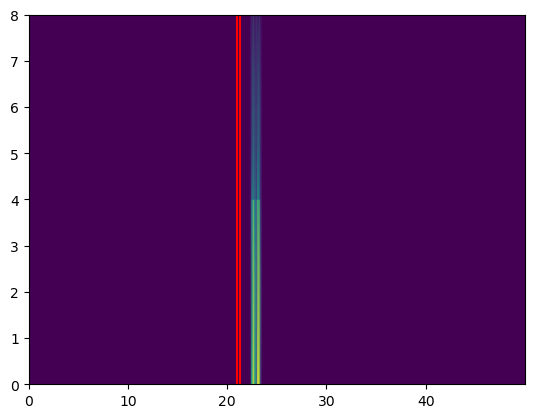

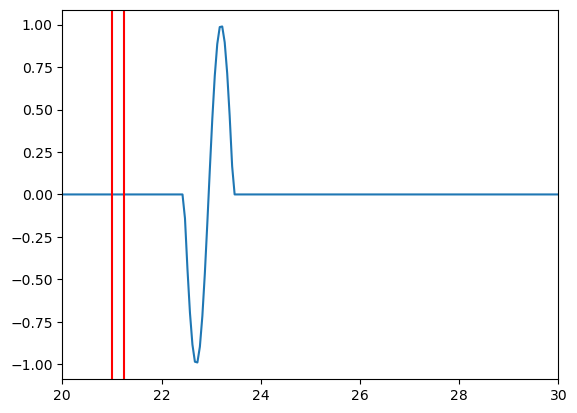

Frame size = 5 samples = 0.25 seconds
Hopsize = 2.5 samples = 0.125 seconds
Number of frames = 401.0 frames
Number of frequency values = 3.5
Time resolution = 0.125 seconds
Frequency resolution = 4.0 Hz
Sampling rate = 20.0 samples per second
Maximum frequency = 10.0 Hz


In [7]:
# STFT testing program
# [Written by Marcel Szczech during URSS project on lamb wave mode isolation]

                      ########## What does this program do, and what is it intended for? ##########
# This program is essentially a short-time Fourier transform (STFT) applied to a test signal, wich is made up of a sine wave 'pulse' which 
# appears at some customisable point in the signal domain, and lasts for a specified amount of time. I made it to convince myself how
# an STFT works, and also to play around with the parameter known as 'frame size' (or sometimes 'window size') and see how it affects the
# output of an STFT.

                          ########## Brief overview of my understanding of an STFT ##########
# The STFT works by splitting up a given input signal into several segments called FRAMES; the signal portion inside each frame is 
# multiplied by a 'window function', after which the portion has a discrete Fourier transform (DFT) applied to it. The absolute value of a 
# particular DFT gives an amplitude-frequency graph for the portion that DFT corresponds to, essentially telling you what frequencies are 
# present to what strengths for that portion. The STFT output is then all of the amplitude-frequency graphs for all the frames plotted 
# together on a heatmap, where on the horizontal axis you have time (of the input signal), the vertical axis gives frequency, and the 
# colour represents the 'amplitude' or 'strength' of a particular frequency at a particular point in time in the signal.

            ########## My understanding of the steps for carrying out an STFT and displaying the output ##########
# 1) Necessary parameters for the STFT are defined. Two of these, HOPSIZE and FRAMESIZE can be customised; SAMPLINGRATE is set by the 
# properties of the input signal and cannot be decided. HOPSIZE is the distance between starting points of subsequent frames of the STFT 
# on which DFTs are carried out, measured in number of sample points. FRAMESIZE is the number of sample points in one frame. 
# SAMPLINGRATE is the number of sample points per unit time in the input signal. So in summary, for this step, these are defined:
# -> HOPSIZE
# -> FRAMESIZE
# -> SAMPLINGRATE

# 2) The signal in each frame is multiplied by a 'window function', which is typically defined over the length of a frame. Often the
# window function is the 'Hanning Window', which resembles a bell curve, so the windowed signal portion for a particular frame goes to 
# 0 near the ends of the frame.

# 3) A discrete Fourier transform is applied onto each windowed frame, and the absolute value of each DFT is taken, producing an 
# amplitude-frequency graph for each windowed frame.

# 4) The DFT information for each frame is plotted as a heatmap on a frequency-time plane, where the colour or 'height' represents the 
# amplitude of a particular frequency at a particular time. The DFTs are taken over frames, and in the heatmap, vertical strips at 
# constant time represent the amplitude-frequency graphs for a particular time. Importantly, the amplitude-frequency information of a 
# frame is shown as the vertical strip AT THE CENTRE TIME OF THAT PARTICULAR FRAME (at least by default in scipy.stft); for the times 
# within the next hopsize interval, there is no new DFT so technically the vertical strips of amplitude vs frequency should not change. 
# But, in plt.pcolormesh, using shading = 'gouraud' makes it so that the vertical strips are gradually shaded WITHIN HOPSIZE INTERVALS
# even though the DFT information within hopsize intervals of frame centre times doesn't actually change. So between times corresponding
# to centres of frames, the amplitudes of the frequencies are interpolated.

                                   ########## IMPORTANT CONCEPTUAL NOTES ##########

                  ########## Where are the first and final frames, and how many are there? ##########
# There is some nuance behind what starting and end times of the first and final frames to use, which is elaborated when defining the 
# number of frames (FRAMENUMBER) later on.

                                    ########## What framesize to use? ##########
# It is important to consider the time interval of wave features in your data before setting the framesize. One has to strike a balance
# between too large of a frame and too small of frame. 

# -> Selecting too large of a frame means that the time at which the frequency is detected will become more 'blurred'; this is because
# the wave feature will only take up a small fraction of the frame it falls in. The DFT fourier coefficient amplitudes calculated for
# a particular frame are placed as the vertical strip of color AT THE CENTRE OF THE FRAME, and between the centre of the frame and 
# its edges, the vertical strips of color are interpolated. So for instance if we have a very brief wavepacket in the middle of noise,
# which has a mean frequency of 0, and we use a large framesize, the colour of the heatmap in the frame containing the wavepacket will be
# interpolated from whatever the value is in the middle of the frame, to '0 amplitude colour' towards the edges, making the heatmap
# intensity seem more spread out. You can think of this as 'losing temporal resolution'; it becomes less clear at what time the 
# wavepacket is 'detected'. This increases the frequency resolution since frequency resolution is proportional to 
# 1/[number of frequency values], and number of frequency values is proportional to the framesize.

# -> Selecting too small of a frame means that a wavepacket's size would stretch multiple frames. This means that where the frames cover
# approximately linear regions of the wavepacket, the DFT of those frames would record essentially a frequency of 0. When the frames get
# closer to the peaks and troughs of the wavepacket, a larger amplitude, finite frequency would be recorded in the DFT of those frames.
# Therefore, we observe a 'wave splitting' effect, where each peak and trough of the wave comes up as a bright patch (of the same
# frequency), leading to a potential misinterpretation of 1 wavepacket as 2 seperate ones. You can think of this as 'increasing the 
# temporal resolution', too much of which can lead to recording multiple wavepackets when there were less. 
# This decreases the frequency resolution since frequency resolution is proportional to 1/[number of frequency values], and number of 
# frequency values is proportional to the framesize.

# In summary, increasing framesize: 
# -> increases frequency resolution
# -> decreases 'temporal' resolution

# I found it was good practice to first inspect the raw signal to see the size of your wavepacket feature, and then make the framesize 
# to be such that one frame approximately covers 1 'cycle' of the wavepacket. 


                                        ########## The program itself ##########

# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft


# Time domain of signal, and number of samples, or points, the signal has.

starttime=0
endtime=50
samplenumber=1000
time = np.linspace(starttime, endtime, samplenumber)


# Making a test signal, made up of a sine wave pulse, on either side padded with 0 values. Can modify for any function(s) you like. 
# Use np.concatenate to join several sub-signals together... Just remember to define each signal on the correct subdomain of time when 
# slicing!

signal1 = np.zeros(449) # Set this to be how many 0 values you want to the left of your sine pulse.

freq1 = np.sin(2*np.pi*1*time[450:470]) # Set the two indices of 'time[:]' to stretch from the beginning and final sample points 
                                        # you want your sine pulse to exist over. You can also set the frequency of the sine wave;
                                        # I have written it out so that we have '2 times pi times frequency' inside the sine argument

signal2 = np.zeros(531) # This argument should be 1+ (samplenumber - the second index inside the freq1); the number of 0 values to the
                        # right of the sine pulse.

SIGNAL = np.concatenate((signal1, freq1, signal2))


# Paramaters of the signal and the STFT 
# The 3 frame parameters YOU decide are the three mentioned earlier; framesize, hopsize, and framenumber. In addition, there are some
# parameters which cannot be decided, or are fixed once the 3 mentioned above are selected:

# -> 'samplingrate' cannot be customised and is simply the number of points per unit time in the input signal. 
# -> 'overlap', 'frequencybins', 'frequencymax', 'frequency_resolution', 'time_resolution' are then calculated from all the other 
#     parameters.

samplingrate = samplenumber/(endtime-starttime) 
# The number of points per second in the raw signal. Have to define this as it is one of the necessary arguments in the STFT.

# Quickly define a function for converting from sample intervals to time intervals; it is more intuitive to think of hopsize, framesize 
# etc. in time rather than number of data points for clarity.

def dT(dN):
    return dN / samplingrate

framesize = 1*5
# When the STFT carries out DFTs on small 'frames' of the signal, this is the number of points in one frame. Ideally set this is a factor 
# of the original signal length.

hopsize = 0.5*framesize 
# This is the distance between starting points of subsequent frames of the STFT on which DFTs are carried out. The 0.5 is arbitrary
# and in theory can be changed.

overlap = framesize - hopsize 
# This is how many points subsequent frames share. It is one of the arguments of scipy.stft and is effectively the same as defining hopsize
# once framesize is fixed. I found hopsize easier to think about in my head which is why I defined it first; this is here just so we can
# pass it into scipy.stft later on.

frequencybins = (framesize/2) + 1 
# This is the number of frequencies for which complex fourier coefficients are calculated for each frame DFT.

framenumber = ((samplenumber-framesize)/(hopsize)) + 1 + 2 
# This is the number of frames scipy.stft considers by default. Maybe you'd intuitively expect there to be a number of frames such that 
# the first frame starts on the first point of the raw signal, and the last frame starts so that it covers the final framesize of 
# data points. In this case the number of frames would be (samplenumber-framesize)/hopsize + 1; you can draw a diagram to convince 
# yourself. However, by default, scipy.stft considers two additional frames; one extra at the beginning, starting a hopsize behind the 
# start time of the signal, and one extra at the end, starting a hopsize before the end time of the signal. This makes it so that the 
# centre of the first frame is on the first point of the signal, and the centre of the last frame is on the last point of the signal.
# By default, the regions of these added extra frames extending outside the domain of the original signal are zero-padded. If you want to
# have frames only considering raw data points, you can insert 'boundary=None, padded=False' after the 'noverlap' argument of scipy.stft.
# Having the first and last frames centred on the first and last data points means that when the hanning window function is applied on
# these frames, the signal values at the starting and end times aren't suppressed to 0, which WOULD happen if the first and last frames 
# started and ended on the first and last data points respectively, since the hanning window function goes to 0 towards the ends of frames.
# So use the default padding feature if you want your start and end signal values to not be supressed in the STFT.
# The reason I have '+ 1 + 2' at the end seems weird but it is more for inuition; keep only the +1 if you have no padding; keep the +2 
# aswell if you have padding, which is on by default.

frequencymax = samplingrate/2 
# The maximum frequency which can be 'detected' by the STFT; this is a mathematical result

frequency_resolution = frequencymax / (frequencybins - 1)
# The frequency difference between values of frequency for which complex fourier coefficients are calculated in the DFTs.

time_resolution = dT(hopsize)
# The time interval between DFTs being taken, or the the time interval between the beginnings of frames. Effectively the hopsize in 
# units of time.


# Carrying out the STFT on the signal; 
# -> f is the array of frequency values for which complex fourier coefficients are calculated for in the DFT of a frame.
# -> t is the array of centre times of the frames.
# -> Zxx is a 2D array, where the complex fourier coefficients for a particular frequency are stored as a function of time; the first 
# axis sweeps through frequencies, from 0 onwards to 'frequencymax', the second axis sweeps through frame centre times. 
    
f, t, Zxx = stft(SIGNAL, fs=samplingrate, nperseg=framesize, noverlap=overlap)


# Plotting the magnitude of the DFTs of the frames as colour on a heatmap
plt.pcolormesh(t[:], f, np.abs(Zxx[:, :]), shading='gouraud',vmin=0, vmax=np.max(np.abs(Zxx))*0.9)
# Look at specific regions if you like:
#plt.ylim([0,2])
#plt.xlim([20,30])

# Plotting frame boundaries on the heatmap, of the Nth frame. Remember there is a 'framenumber' number of frames.
N=170
plt.axvline(x=(N)*dT(hopsize), color='r')
plt.axvline(x=(N-2)*dT(hopsize), color='r')

plt.show()


# Plotting the raw signal, and the frame boundaries of the Nth frame. Remember there is a 'framenumber' number of
# frames.
plt.plot(time, SIGNAL)

#Look at specific regions if you like:
#plt.ylim([0,2])
plt.xlim([20,30])

# The frame boundaries of the Nth frame
plt.axvline(x=(N)*dT(hopsize), color='r')
plt.axvline(x=(N-2)*dT(hopsize), color='r')
plt.show()

# Printing useful parameters for sanity checks
print("Frame size =", framesize, "samples =", dT(framesize), "seconds")
print("Hopsize =", hopsize, "samples =", dT(hopsize), "seconds")
print("Number of frames =", framenumber, "frames")
print("Number of frequency values =", frequencybins)
print("Time resolution =", dT(hopsize), "seconds")
print("Frequency resolution =", frequency_resolution, "Hz")
print("Sampling rate =", samplingrate, "samples per second")
print("Maximum frequency =", frequencymax, "Hz")

#test printing to check understanding of the arrays. Can add/remove/comment/uncomment things as you wish.
#print(time[0], time[-1], len(time))
#print(t[0], t[1], t[-1], t[-2], len(t))
#print(len(Zxx), len(Zxx[0]), np.shape(Zxx))
#print(np.shape(f), f[0], f[-1])
